# BoW Model

In this notebook, I will use count vector related measures (e.g. TF-IDF) to classify the sentiment.  

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

from timeit import default_timer as timer
from custom_functions import clean_up, evaluating, scoring, get_pred

In [90]:
X_train = pd.read_pickle('PKL/X_train_fin.pkl')
X_val = pd.read_pickle('PKL/X_val_fin.pkl')
y_train = pd.read_csv('DATA/y_train.csv', index_col=0)
y_val = pd.read_csv('DATA/y_val.csv', index_col=0)

In [91]:
X_train_other = X_train.drop(['tweet'], axis = 1)
X_val_other = X_val.drop(['tweet'], axis = 1)

In [92]:
y_train = y_train['sentiment']
y_val = y_val['sentiment']

## Evaluation Metrics
It is a multi-class classification problem with class imbalance. Since the goal of the project is to build a model that accurately classifies positive, negative or neutral sentiment than detecting any specific class, while significant class imbalance exists, I'll use macro f1 score as evaluation metric. I'll also look at cohen's kappa score for overall model quality.

## Dummy Classifier
Let's see what our baseline is.

In [93]:
from sklearn.dummy import DummyClassifier

In [94]:
dummyc = DummyClassifier()
dummyc.fit(X_train['tweet'], y_train)

The default value of strategy will change from stratified to prior in 0.24.


DummyClassifier()

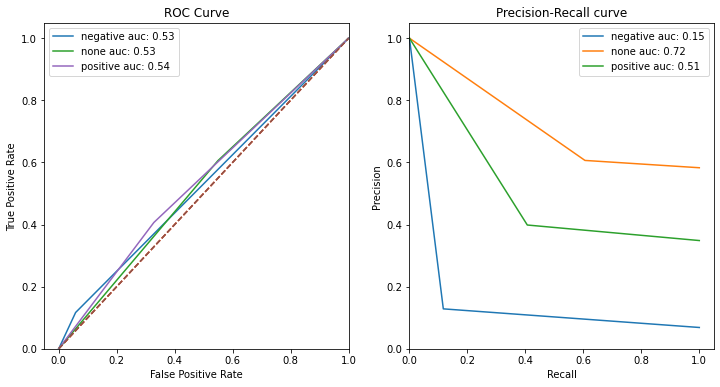

accuracy score:  0.4572 cohens kappa:  -0.0237
                                    precision    recall  f1-score   support

                  Negative emotion       0.05      0.04      0.04        77
No emotion toward brand or product       0.58      0.58      0.58       654
                  Positive emotion       0.32      0.33      0.33       391

                          accuracy                           0.46      1122
                         macro avg       0.32      0.32      0.32      1122
                      weighted avg       0.45      0.46      0.46      1122



In [95]:
y_pred, y_pred_p = get_pred(dummyc, X_val['tweet'])
evaluating(y_val, y_pred, y_pred_p)

0.32 Macro F-1, 45% Accuracy, Cohen's Kappa 0.0

## Count Vectors
I'll start with simple count vectors.

In [96]:
from sklearn.feature_extraction.text import CountVectorizer

countvec = CountVectorizer(ngram_range = (1, 2), min_df = 2, max_df = 4000)
X_train_count = countvec.fit_transform(X_train.tweet)

### Class Imbalance
Currently our dataset has a class imbalance issue. I'll first try to resolve this by oversampling using SMOTE.

In [97]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(n_jobs = 3, random_state=22)
X_train_count, y_train_count = smote.fit_resample(X_train_count, y_train)

### Naive-Bayes Model

In [98]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, auc, roc_curve, precision_recall_curve

mn_nb = MultinomialNB()
model = Pipeline([('vectorize', countvec), ('classify', mn_nb)])
model['classify'].fit(X_train_count, y_train_count)

MultinomialNB()

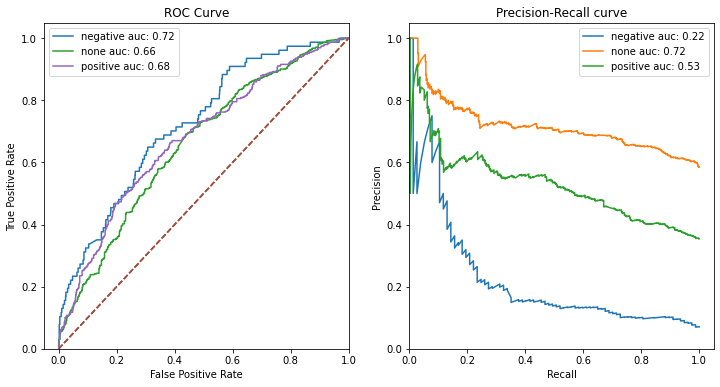

accuracy score:  0.5499 cohens kappa:  0.218
                                    precision    recall  f1-score   support

                  Negative emotion       0.19      0.31      0.24        77
No emotion toward brand or product       0.70      0.55      0.61       654
                  Positive emotion       0.49      0.60      0.54       391

                          accuracy                           0.55      1122
                         macro avg       0.46      0.49      0.46      1122
                      weighted avg       0.59      0.55      0.56      1122



In [99]:
y_pred, y_pred_p = get_pred(model, X_val['tweet'])
evaluating(y_val, y_pred, y_pred_p)

Performance is not quite optimal. Especially predicting negative emotion is very bad. Less than 35% of true cases were detected, and even with the ones predicted they were mostly wrong.

## TF-IDF Score
Let's use more advanced count measures. I'll try TF-IDF score.

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vectorizer = TfidfVectorizer(ngram_range = (1, 2), min_df = 2, 
                                max_features= 4000)
X_train_tf = tf_vectorizer.fit_transform(X_train.tweet)

In [101]:
# oversampling
smote = SMOTE(n_jobs = 3, random_state=22)
X_train_tf_r, y_train_tf_r = smote.fit_resample(X_train_tf, y_train)

In [102]:
# native-bayes
mn_nb = MultinomialNB()
model = Pipeline([('vectorize', tf_vectorizer), ('classify', mn_nb)])
model['classify'].fit(X_train_tf_r, y_train_tf_r)

MultinomialNB()

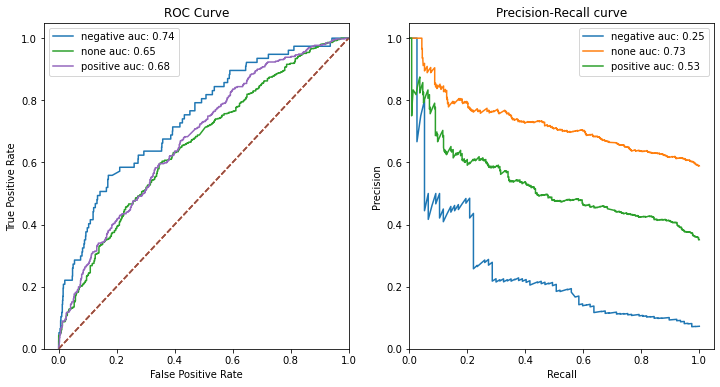

accuracy score:  0.5303 cohens kappa:  0.2176
                                    precision    recall  f1-score   support

                  Negative emotion       0.20      0.55      0.29        77
No emotion toward brand or product       0.70      0.53      0.60       654
                  Positive emotion       0.50      0.53      0.51       391

                          accuracy                           0.53      1122
                         macro avg       0.47      0.53      0.47      1122
                      weighted avg       0.59      0.53      0.55      1122



In [103]:
y_pred, y_pred_p = get_pred(model, X_val['tweet'])
evaluating(y_val, y_pred, y_pred_p)

Okay. Overall accuracy is not great, but at least this does a better job at catching all three classes about 50% correctly. It seems like it's falsely biasing towards minority class though. Overall bias is high. 

## SVM
---

In [24]:
import optuna
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC

In [ ]:
def find_hyperparam_svm(trial):
    C = trial.suggest_loguniform('C', 0.0001, 1)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    tol = trial.suggest_loguniform('tol', 0.00001, 0.1)
    svc = SVC(probability = True, 
              C = C,
              gamma = gamma,
              tol = tol,
              class_weight = 'balanced'
             )
    cv = KFold(n_splits = 7, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(svc, X_train_tf, y_train,
                                    scoring = 'f1_macro', cv = cv, n_jobs = -1))
    return (score)

#svm_study = optuna.create_study(direction='maximize')
svm_study.optimize(find_hyperparam_svm, timeout = 3600)

In [104]:
svm_study.best_params

{'C': 0.8105657687211771, 'gamma': 'scale', 'tol': 0.013398131464385314}

In [105]:
svm1 = SVC(class_weight = 'balanced', 
           **svm_study.best_params, 
           probability= True)

svm1.fit(X_train_tf, y_train)

SVC(C=0.8105657687211771, class_weight='balanced', probability=True,
    tol=0.013398131464385314)

In [106]:
X_val_tf = tf_vectorizer.transform(X_val.tweet)

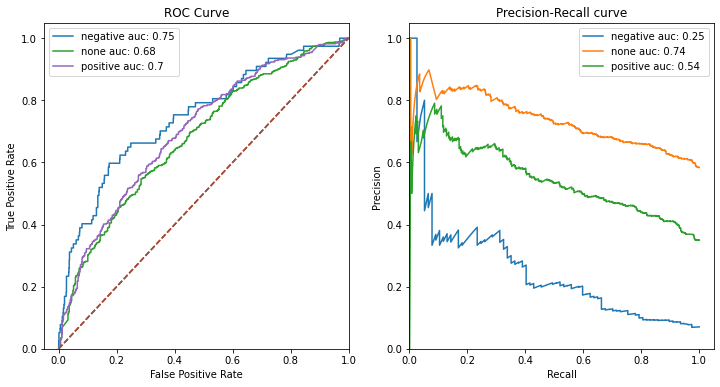

accuracy score:  0.6159 cohens kappa:  0.2515
                                    precision    recall  f1-score   support

                  Negative emotion       0.38      0.13      0.19        77
No emotion toward brand or product       0.68      0.72      0.70       654
                  Positive emotion       0.53      0.54      0.53       391

                          accuracy                           0.62      1122
                         macro avg       0.53      0.46      0.47      1122
                      weighted avg       0.60      0.62      0.61      1122



In [107]:
y_pred, y_pred_p = get_pred(svm1,X_val_tf)
evaluating(y_val, y_pred, y_pred_p)

In [108]:
svm_study.best_value

0.4880336671530897

No overfitting. But prediction of minority class is consistently bad. 

## Shapely Evaluation
Let's use SHAP to figure out which features are contributing the most to classifications.

In [18]:
import shap

In [19]:
shap.initjs()

In [109]:
sample = shap.kmeans(X_train_tf, 10)
e = shap.KernelExplainer(svm1.predict_proba, sample, link = 'logit')

In [110]:
shap_vals = e.shap_values(X_val_tf, nsamples = 100)

In [111]:
shap.force_plot(e.expected_value[0], shap_vals[0][0,:],
                tf_vectorizer.get_feature_names())

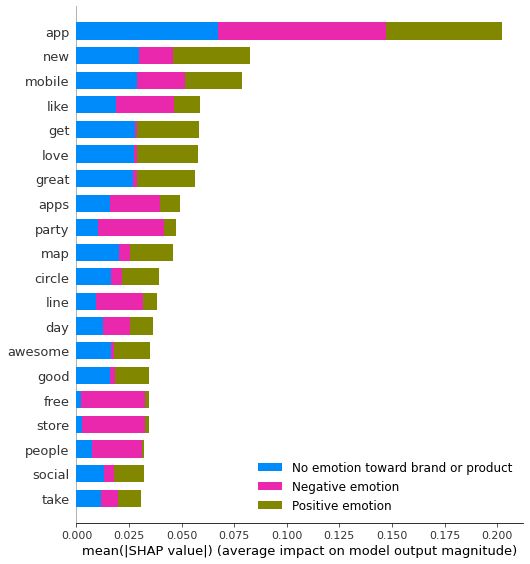

In [112]:
shap.summary_plot(shap_vals, feature_names = tf_vectorizer.get_feature_names(),
                 class_names = svm1.classes_)